# Installs & Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers, models, utils
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from scipy import sparse
import random
import os

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Loading the Data

In [ ]:
# Load the dataset with the 10,000 most common words
num_words=10000

(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

# Exploring the Data

In [ ]:
# Inspect the data shapes
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}\n")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (25000,)
Shape of y_train: (25000,)

Shape of X_test: (25000,)
Shape of y_test: (25000,)


In [ ]:
# Convert integers to words
word_index = keras.datasets.imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print(f"The most common word is: {reverse_word_index[1]}")

The most common word is: the


In [ ]:
# Print 100 most common tokens
most_common_words = [
    reverse_word_index.get(i - 3, '?') for i in range(3, num_words + 3)
]
print(most_common_words[:100])

['?', 'the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just', 'about', "it's", 'out', 'has', 'if', 'some', 'there', 'what', 'good', 'more', 'when', 'very', 'up', 'no', 'time', 'she', 'even', 'my', 'would', 'which', 'only', 'story', 'really', 'see', 'their', 'had', 'can', 'were', 'me', 'well', 'than', 'we', 'much', 'been', 'bad', 'get', 'will', 'do', 'also', 'into', 'people', 'other', 'first', 'great', 'because', 'how', 'him', 'most', "don't", 'made', 'its', 'then', 'way', 'make', 'them', 'too', 'could', 'any', 'movies']


In [ ]:
# Function to decode reviews
def decode_review(text):
    decoded = ' '.join([reverse_word_index.get(i - 3, '?') for i in text])
    return decoded

# Inspect a sample review
print(decode_review(X_train[0]))
print("Label:", "Positive" if y_train[0] == 1 else "Negative")

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [ ]:
# Inspect five random reviews
for i in range(5):
    index = np.random.randint(0, len(X_train))
    print(f"Review: {decode_review(X_train[index])}")
    print("Label:", "Positive" if y_train[index] == 1 else "Negative", "\n")

Review: ? amazing movie i saw this movie for the first time on a flight and could not believe that i had not even heard of it before getting on that plane while it may seem at first to be a chick flick it is a film that everyone should see and will enjoy men watch this movie with someone you love you will enjoy it as much as she does and it will score you big points
Label: Positive 

Review: ? i screamed my head off because seeing this movie was my first movie going experience ever at some 13 months old i remember it being incredibly bloody and it made me angry i watched it again on tv a few years ago big mistake the acting is wooden the plot non existent and the movie lacks merit unless 23 year old t a is what gets you going 0
Label: Negative 

Review: ? lets make a movie about a talk show that already exists and basically have everything that happens on the show well if that idea doesn't intrigue you which it shouldn't stay away from ? i had the ? of seeing this in the theater and ac

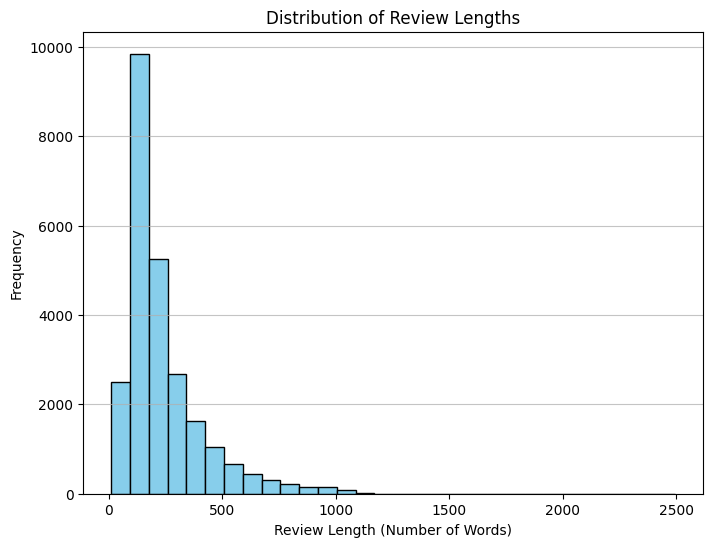

In [ ]:
# Visualize length distribution
review_lengths = [len(review) for review in X_train]
plt.figure(figsize=(8, 6))
plt.hist(review_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length (Number of Words)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

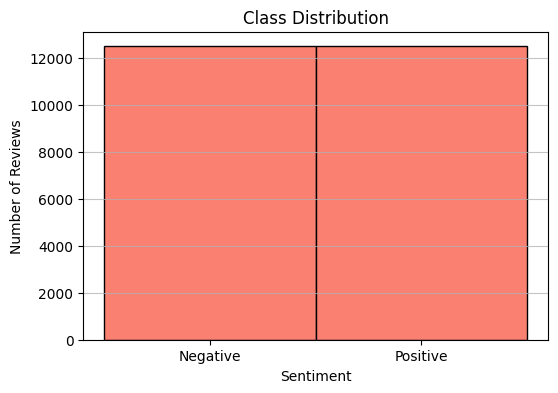

In [ ]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
plt.hist(y_train, bins=[-0.5, 0.5, 1.5], color='salmon', edgecolor='black')
plt.title("Class Distribution")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', alpha=0.75)
plt.show()

# Splitting the Data

In [ ]:
# Split the test data into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test,
    test_size=0.5,
    stratify=y_test,
    random_state=42
)

In [ ]:
# Shuffle the training set
np.random.seed(SEED)
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

In [ ]:
# Check the partition shapes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}\n")

print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}\n")

print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (25000,)
y_train: (25000,)

X_val: (12500,)
y_val: (12500,)

X_test: (12500,)
y_test: (12500,)


In [ ]:
# Check the class balances
print(f"y_train: {np.bincount(y_train)}")
print(f"y_val: {np.bincount(y_val)}")
print(f"y_test: {np.bincount(y_test)}")

y_train: [12500 12500]
y_val: [6250 6250]
y_test: [6250 6250]


# Utility Functions

In [ ]:
# Function to create callbacks
def create_callbacks(verbose=1, early_stopping_patience=5, reduce_lr_patience=2, monitor="val_loss"):
    # Early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor=monitor,
        patience=early_stopping_patience,
        restore_best_weights=True,
        verbose=verbose
    )

    # Reduce LR on plateau
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor=monitor,
        factor=0.1,
        patience=reduce_lr_patience,
        verbose=verbose,
        min_delta=1e-2,
        mode="min"
    )

    return [early_stopping, reduce_lr]

In [ ]:
# Function to visualize training history
def plot_training_history(history):
    # Dynamically determine the number of epochs
    epochs_range = range(1, len(history.history["loss"]) + 1)

    # Plot losses
    plt.figure(figsize=(15, 6))
    plt.plot(epochs_range, history.history.get("loss", []), label="Train Loss")
    plt.plot(epochs_range, history.history.get("val_loss", []), label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure(figsize=(15, 6))
    if "accuracy" in history.history:
        plt.plot(epochs_range, history.history["accuracy"], label="Train Accuracy")
    if "val_accuracy" in history.history:
        plt.plot(epochs_range, history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
# Function to get metrics DataFrame
def get_model_metrics(model, X, y, model_type="ml"):
    # Get predictions
    if model_type == "ml":
        y_pred = model.predict(X)
        try:
            y_pred_proba = model.predict(X)
        except:
            y_pred_proba = None
    elif model_type == "dl":
        y_pred = (model.predict(X) > 0.5).astype("int32")
        y_pred_proba = model.predict(X)

    # Calculate metrics
    metrics = {
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1 Score": f1_score(y, y_pred)
    }

    if y_pred_proba is not None:
        try:
            metrics["ROC-AUC"] = roc_auc_score(y, y_pred_proba[:, 1])
        except IndexError:
            metrics["ROC-AUC"] = roc_auc_score(y, y_pred_proba)

    # Create DataFrame
    metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Score"])
    return metrics_df

# DV-NGNB with DF-ICF

In [ ]:
# Define Document Frequency Inverse Corpus Frequency Class
class DFICFVectorizer(CountVectorizer):
    def fit_transform(self, raw_documents, y=None):
        # Transform documents to document-term matrix using CountVectorizer
        X = super().fit_transform(raw_documents, y)

        # Convert X to binary format for DF calculation
        X_binary = (X > 0).astype(int)

        # Calculate Document Frequency (DF)
        self.df_ = np.array(X_binary.sum(axis=0)).flatten()

        # Store the number of documents for ICF calculation during transform
        self.n_samples_ = X.shape[0]

        # Calculate Inverse Corpus Frequency (ICF)
        icf = np.log((self.n_samples_ + 1) / (1 + self.df_))

        # Compute DF-ICF
        df_icf = X.multiply(icf)

        return df_icf

    def transform(self, raw_documents):
        # Transform documents to document-term matrix
        X = super().transform(raw_documents)

        # Calculate Inverse Corpus Frequency (ICF) using DF from fit
        icf = np.log((self.n_samples_ + 1) / (1 + self.df_))

        # Compute DF-ICF
        df_icf = X.multiply(icf)

        return df_icf

In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix

# Define Document Vector N-Gram NaiveBayes-Weighted Embedding Class
class DocVecNGNB:
    def __init__(self, ngram_range=(1, 3), embedding_dim=50, vocab_size=10000, epochs=10, batch_size=32):
        self.vectorizer = DFICFVectorizer(ngram_range=ngram_range, max_features=vocab_size)
        self.embedding_dim = embedding_dim
        self.epochs = epochs
        self.batch_size = batch_size

    def build_model(self, input_dim):
        # Input layer (accepts a sparse matrix)
        input_layer = layers.Input(shape=(input_dim,), sparse=True)

        # Lambda layer to convert sparse input to dense
        dense_input = layers.Lambda(lambda x: tf.reshape(tf.sparse.to_dense(x, default_value=0), [-1, input_dim]))(input_layer)

        # Dense layer
        dense_layer = layers.Dense(self.embedding_dim, activation="relu")(dense_input)

        # Dropout layer
        dropout_layer = layers.Dropout(0.2)(dense_layer)

        # Output layer
        output_layer = layers.Dense(1, activation="sigmoid")(dropout_layer)

        # Create the model
        model = keras.Model(inputs=input_layer, outputs=output_layer)

        # Compile the model
        model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001), loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
        return model

    def fit(self, documents, labels, validation_data=None, epochs=None, batch_size=None):
        # Set training parameters
        epochs = epochs if epochs is not None else self.epochs
        batch_size = batch_size if batch_size is not None else self.batch_size

        # Vectorize the documents
        X = self.vectorizer.fit_transform(documents)
        y = np.array(labels).reshape(-1, 1)

        # Train classifier
        nb_classifier = BernoulliNB()
        nb_classifier.fit(X, labels)

        # Use difference in log probs as feature importance weights
        feature_log_probs = nb_classifier.feature_log_prob_
        importance_weights = np.exp(np.abs(feature_log_probs[1] - feature_log_probs[0]))
        X_weighted = X.multiply(csr_matrix(importance_weights))

        # Normalize the weighted features
        X_normalized = normalize(X_weighted, norm="l1", axis=1)
        X_normalized = csr_matrix(X_normalized)

        # Convert sparse matrix to SparseTensor
        sparse_tensor = tf.sparse.SparseTensor(
            indices=np.array(list(zip(*X_normalized.nonzero()))),
            values=X_normalized.data,
            dense_shape=X_normalized.shape
        )
        sparse_tensor = tf.sparse.reorder(sparse_tensor)

        # Build and train the neural network model
        self.model = self.build_model(X.shape[1])

        # Use a Dataset to handle sparse tensor
        dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor, y)).batch(batch_size)

        if validation_data:
            # Process validation data if provided
            X_val, y_val = validation_data
            X_val_transformed = self.vectorizer.transform(X_val)
            X_val_normalized = normalize(X_val_transformed, norm="l1", axis=1)
            X_val_normalized = csr_matrix(X_val_normalized)

            # Convert validation data to SparseTensor
            val_sparse_tensor = tf.sparse.SparseTensor(
                indices=np.array(list(zip(*X_val_normalized.nonzero()))),
                values=X_val_normalized.data,
                dense_shape=X_val_normalized.shape
            )
            val_sparse_tensor = tf.sparse.reorder(val_sparse_tensor)

            val_dataset = tf.data.Dataset.from_tensor_slices((val_sparse_tensor, np.array(y_val).reshape(-1, 1))).batch(batch_size)
        else:
            val_dataset = None

        # Fit the model to the dataset
        self.model.fit(dataset, epochs=epochs, validation_data=val_dataset, callbacks=create_callbacks(verbose=0, early_stopping_patience=10, reduce_lr_patience=3))

    def transform(self, documents, batch_size=None):
        batch_size = batch_size if batch_size is not None else self.batch_size

        # Vectorize the documents
        X = self.vectorizer.transform(documents)

        # Normalize the documents
        X_normalized = normalize(X, norm="l1", axis=1)
        X_normalized = csr_matrix(X_normalized)

        # Convert normalized data to SparseTensor
        sparse_tensor = tf.sparse.SparseTensor(
            indices=np.array(list(zip(*X_normalized.nonzero()))),
            values=X_normalized.data,
            dense_shape=X_normalized.shape
        )
        sparse_tensor = tf.sparse.reorder(sparse_tensor)

        # Prepare a Dataset from the SparseTensor
        dataset = tf.data.Dataset.from_tensor_slices(sparse_tensor).batch(batch_size)

        # Predict with the model
        predictions = self.model.predict(dataset)

        return predictions

    def evaluate(self, documents, labels, batch_size=None):
        batch_size = batch_size if batch_size is not None else self.batch_size

        # Vectorize the documents
        X = self.vectorizer.transform(documents)

        # Normalize the documents
        X_normalized = normalize(X, norm="l1", axis=1)
        X_normalized = csr_matrix(X_normalized)

        # Convert normalized data to SparseTensor
        sparse_tensor = tf.sparse.SparseTensor(
            indices=np.array(list(zip(*X_normalized.nonzero()))),
            values=X_normalized.data,
            dense_shape=X_normalized.shape
        )
        sparse_tensor = tf.sparse.reorder(sparse_tensor)

        # Convert the labels into a numpy array with the correct shape
        y = np.array(labels).reshape(-1, 1)

        # Prepare a Dataset from the SparseTensor
        dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor, y)).batch(batch_size)

        # Evaluate the model on the dataset
        loss, accuracy = self.model.evaluate(dataset)

        return loss, accuracy

In [ ]:
# Create vectorizer instance
doc_vectorizer = DocVecNGNB(epochs=30, batch_size=16)

# Train the vectorizer
doc_vectorizer.fit(
    [decode_review(review) for review in X_train], y_train,
    validation_data=([decode_review(review) for review in X_val], y_val)
)

# Evaluate the vectorizer
val_loss, val_accuracy = doc_vectorizer.evaluate(
    [decode_review(review) for review in X_val],
    y_val
)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch 1/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.4232 - accuracy: 0.8586 - val_loss: 0.3898 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 2/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2404 - accuracy: 0.9098 - val_loss: 0.3455 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 3/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1990 - accuracy: 0.9272 - val_loss: 0.3387 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 4/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1714 - accuracy: 0.9375 - val_loss: 0.3460 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 5/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1506 - accuracy: 0.9468 - val_loss: 0.3600 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 6/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1266 - accuracy: 0.9589 - val_loss: 0.3557 - val_accuracy: 0.8486 - lr: 1.0000e-04
Epoch 7/30
1563/1563 [==============================] 

In [ ]:
# Prepare the data with DV-NGNB approach
X_train_docvec = doc_vectorizer.transform(
    [decode_review(review) for review in X_train]
)

X_val_docvec = doc_vectorizer.transform(
    [decode_review(review) for review in X_val]
)

X_test_docvec = doc_vectorizer.transform(
    [decode_review(review) for review in X_test]
)

782/782 [==============================] - 1s 2ms/step


In [ ]:
# Check shape of transformed data
X_train_docvec.shape, X_val_docvec.shape, X_test_docvec.shape

((25000, 1), (12500, 1), (12500, 1))

In [ ]:
# Train logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_docvec, y_train)

# Evaluate the model
y_val_pred = logreg.predict(X_val_docvec)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.8757


In [ ]:
# Get metrics - Validation Set
logreg_metrics_df = get_model_metrics(logreg, X_val_docvec, y_val, model_type="ml")
logreg_metrics_df

,Score
Accuracy,0.875680
Precision,0.869182
Recall,0.884480
F1 Score,0.876764
ROC-AUC,0.875680


In [ ]:
# Get metrics - Test Set
logreg_metrics_df = get_model_metrics(logreg, X_test_docvec, y_test, model_type="ml")
logreg_metrics_df

,Score
Accuracy,0.879120
Precision,0.870872
Recall,0.890240
F1 Score,0.880449
ROC-AUC,0.879120


In [ ]:
# Function to build the model
def build_model(input_dim):
    model = keras.Sequential([
        layers.Dense(20, activation="relu", input_shape=(input_dim,)),
        layers.Dropout(0.1),
        layers.Dense(10, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.AdamW(),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
# Train the neural network model
nn_model = build_model(input_dim=X_train_docvec.shape[1])
history = nn_model.fit(
    X_train_docvec, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_val_docvec, y_val),
    callbacks=create_callbacks(early_stopping_patience=10, reduce_lr_patience=3)
)

Epoch 1/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3329 - accuracy: 0.8799 - val_loss: 0.3212 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 2/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2116 - accuracy: 0.9274 - val_loss: 0.3330 - val_accuracy: 0.8755 - lr: 0.0010
Epoch 3/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2060 - accuracy: 0.9322 - val_loss: 0.3319 - val_accuracy: 0.8749 - lr: 0.0010
Epoch 4/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9314
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2022 - accuracy: 0.9314 - val_loss: 0.3276 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 5/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1980 - accuracy: 0.9313 - val_loss: 0.3274 - val_accuracy: 0.8758 - lr: 1.0000e-04
Epoch 6/30
1563/1563 [=========================

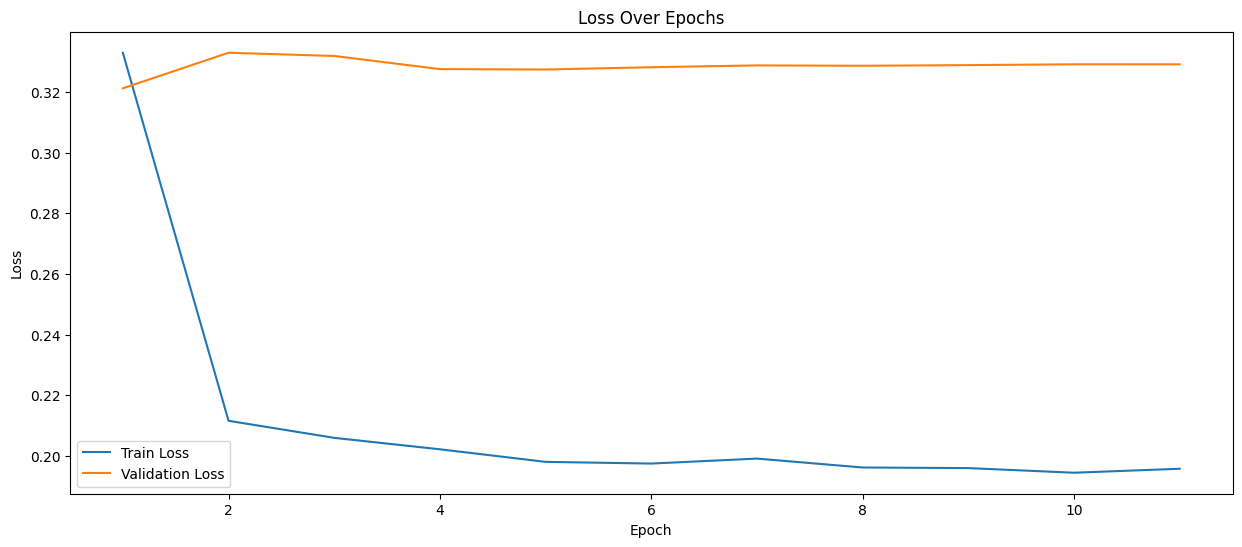

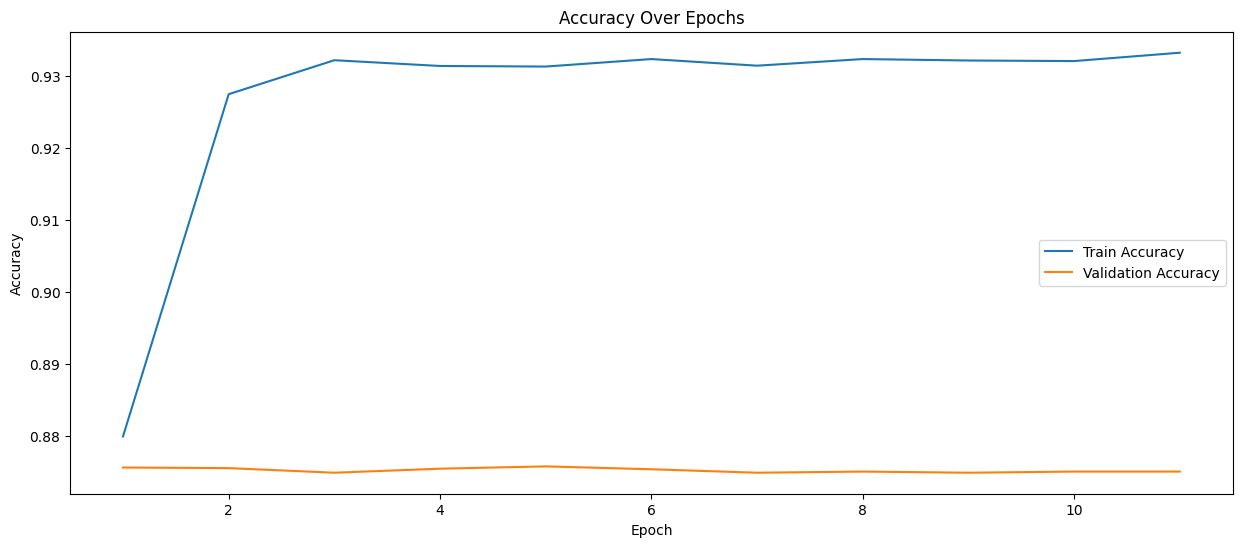

In [ ]:
# Visualize the training history
plot_training_history(history)

In [ ]:
# Get metrics - Validation Set
nn_metrics_df = get_model_metrics(nn_model, X_val_docvec, y_val, model_type="dl")
nn_metrics_df

391/391 [==============================] - 1s 1ms/step


,Score
Accuracy,0.875600
Precision,0.866969
Recall,0.887360
F1 Score,0.877046
ROC-AUC,0.944523


In [ ]:
# Get metrics - Test Set
nn_metrics_df = get_model_metrics(nn_model, X_test_docvec, y_test, model_type="dl")
nn_metrics_df

391/391 [==============================] - 1s 1ms/step


,Score
Accuracy,0.878480
Precision,0.868401
Recall,0.892160
F1 Score,0.880120
ROC-AUC,0.947890


# DV-NGGB with TF*PDF

In [ ]:
# Define Term Frequency Proportional Document Frequency Class
class TFPDFVectorizer(CountVectorizer):
    def fit_transform(self, raw_documents, y=None):
        # Get term frequencies (TF) using CountVectorizer
        X = super().fit_transform(raw_documents, y)

        # Calculate Proportional Document Frequency (PDF)
        df = np.bincount(X.indices, minlength=X.shape[1])
        self.pdf_ = df / X.shape[0]

        # Compute TF*PDF
        tf_pdf = X.multiply(self.pdf_)

        return tf_pdf

    def transform(self, raw_documents):
        # Transform documents to document-term matrix
        X = super().transform(raw_documents)

        # Calculate Proportional Document Frequency (PDF)
        tf_pdf = X.multiply(self.pdf_)

        return tf_pdf

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Decode the reviews
X_train_decoded = [decode_review(review) for review in X_train]
X_val_decoded = [decode_review(review) for review in X_val]
X_test_decoded = [decode_review(review) for review in X_test]

# Tag the reviews for Doc2Vec
X_train_tagged = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(X_train_decoded)]

# Train Doc2Vec
doc2vec_model = Doc2Vec(vector_size=50, window=2, min_count=1, workers=4, epochs=40, dm=0)
doc2vec_model.build_vocab(X_train_tagged)
doc2vec_model.train(X_train_tagged, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [ ]:
# Create n-grams
ngram_vectorizer = TFPDFVectorizer(ngram_range=(1, 3))

X_train_ngrams = ngram_vectorizer.fit_transform(X_train_decoded)
X_val_ngrams = ngram_vectorizer.transform(X_val_decoded)
X_test_ngrams = ngram_vectorizer.transform(X_test_decoded)

# Reduce dimensionality
n_components = 50
nmf = NMF(n_components=n_components, l1_ratio=0.5, init="nndsvd", max_iter=200, random_state=42)

X_train_reduced = nmf.fit_transform(X_train_ngrams)
X_val_reduced = nmf.transform(X_val_ngrams)
X_test_reduced = nmf.transform(X_test_ngrams)

# Train the gradient boosting classifier
gb_model = GradientBoostingClassifier().fit(X_train_reduced, y_train)

# Get feature importances and normalize
feature_importances = gb_model.feature_importances_
normalized_importances = feature_importances / feature_importances.max()

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
# Combine Doc2Vec embeddings with weighted reduced features
def combine_features(texts, reduced_features, doc2vec_model, normalized_importances):
    # Ensure normalized importances are in array format
    normalized_importances = np.array(normalized_importances)

    # Weight the reduced features with the importances
    weighted_reduced_features = reduced_features * normalized_importances

    # Get document embeddings
    doc_embeddings = np.vstack([doc2vec_model.infer_vector(text.split()) for text in texts])

    # Combine the document embeddings and weighted reduced features
    combined_features = np.hstack((doc_embeddings, weighted_reduced_features))
    return combined_features

# Apply the function
X_train_combined = combine_features(X_train_decoded, X_train_reduced, doc2vec_model, normalized_importances)
X_val_combined = combine_features(X_val_decoded, X_val_reduced, doc2vec_model, normalized_importances)
X_test_combined = combine_features(X_test_decoded, X_test_reduced, doc2vec_model, normalized_importances)

In [ ]:
# Check shape of transformed data
X_train_combined.shape, X_val_combined.shape, X_test_combined.shape

((25000, 100), (12500, 100), (12500, 100))

In [ ]:
# Train logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_combined, y_train)

# Evaluate the model
y_val_pred = logreg.predict(X_val_combined)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.8790


In [ ]:
# Get metrics - Validation Set
logreg_metrics_df = get_model_metrics(logreg, X_val_combined, y_val, model_type="ml")
logreg_metrics_df

,Score
Accuracy,0.879040
Precision,0.899225
Recall,0.853760
F1 Score,0.875903
ROC-AUC,0.879040


In [ ]:
# Get metrics - Test Set
logreg_metrics_df = get_model_metrics(logreg, X_test_combined, y_test, model_type="ml")
logreg_metrics_df

,Score
Accuracy,0.877520
Precision,0.898766
Recall,0.850880
F1 Score,0.874168
ROC-AUC,0.877520


In [ ]:
# Function to build the model
def build_model(input_dim):
    model = keras.Sequential([
        layers.Dense(20, activation="relu", input_shape=(input_dim,)),
        layers.Dropout(0.1),
        layers.Dense(10, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.AdamW(),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
# Train the neural network model
nn_model = build_model(input_dim=X_train_combined.shape[1])
history = nn_model.fit(
    X_train_combined, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_val_combined, y_val),
    callbacks=create_callbacks(early_stopping_patience=10, reduce_lr_patience=3)
)

Epoch 1/30
1563/1563 [==============================] - 8s 4ms/step - loss: 0.3603 - accuracy: 0.8437 - val_loss: 0.2967 - val_accuracy: 0.8774 - lr: 0.0010
Epoch 2/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2969 - accuracy: 0.8800 - val_loss: 0.2851 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 3/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2883 - accuracy: 0.8836 - val_loss: 0.2875 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 4/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2828 - accuracy: 0.8874 - val_loss: 0.2834 - val_accuracy: 0.8806 - lr: 0.0010
Epoch 5/30
1557/1563 [============================>.] - ETA: 0s - loss: 0.2767 - accuracy: 0.8876
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2769 - accuracy: 0.8874 - val_loss: 0.2802 - val_accuracy: 0.8834 - lr: 0.0010
Epoch 6/30
1563/1563 [=============================

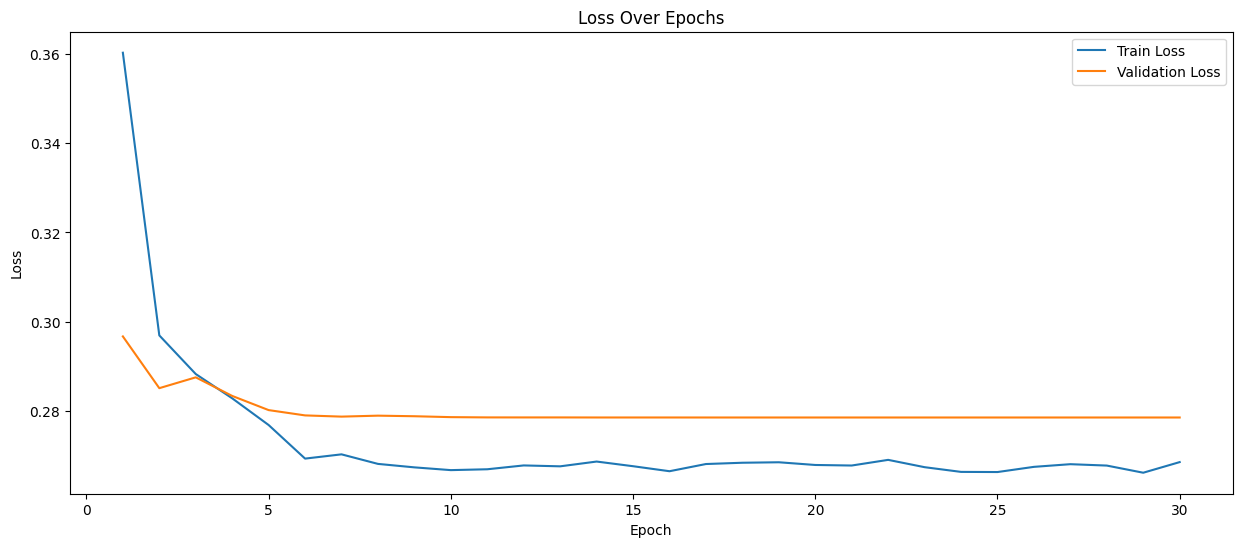

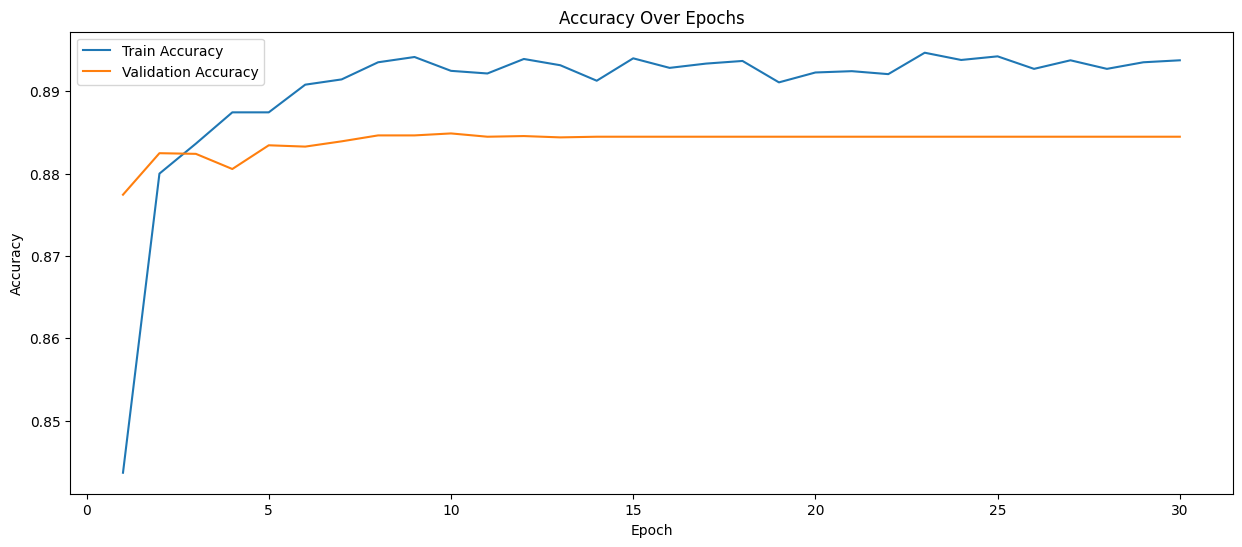

In [ ]:
# Visualize the training history
plot_training_history(history)

In [ ]:
# Get metrics - Validation Set
nn_metrics_df = get_model_metrics(nn_model, X_val_combined, y_val, model_type="dl")
nn_metrics_df

391/391 [==============================] - 1s 2ms/step


,Score
Accuracy,0.884480
Precision,0.892007
Recall,0.874880
F1 Score,0.883360
ROC-AUC,0.953424


In [ ]:
# Get metrics - Test Set
nn_metrics_df = get_model_metrics(nn_model, X_test_combined, y_test, model_type="dl")
nn_metrics_df

391/391 [==============================] - 1s 1ms/step


,Score
Accuracy,0.882560
Precision,0.888907
Recall,0.874400
F1 Score,0.881594
ROC-AUC,0.951659


In [ ]:
# Save the model
nn_model.save("/content/nn_model.tf")